In [1]:
import lib.decoder as decoder 

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch



import time

from tqdm import tqdm

In [2]:
gen = decoder.decoder(32, 'cpu')

In [3]:
# Paramètres de l’orbite
orbit = torch.zeros(1,1,3)

orbit[:,0,0] = 0.5
orbit[:,0,1] = np.deg2rad(45)
orbit[:,0,2] = np.deg2rad(9)

In [4]:
gen_img = gen(orbit) # Image generation

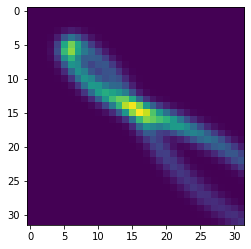

In [5]:
plt.figure()
plt.imshow(gen_img.reshape(32,32).cpu())
plt.show()

## Dataset generation
---



In [98]:
K_train = 1_000
K_test= 1000

img_size = 32

gen = decoder.decoder(img_size, "cpu") # Generator
def gen_dataset(N):
  orbit = torch.zeros(N,1,3)

  orbit[:,0,0] = torch.rand(N)*0.5
  orbit[:,0,1] = np.deg2rad(torch.rand(N)*20+25)#np.deg2rad(torch.rand(N)*20)
  orbit[:,0,2] = np.deg2rad(torch.rand(N)*20-10)

  gen_img = gen(orbit) # Image generation
  return orbit, gen_img

orbit_test, gen_img_test = gen_dataset(K_test)
orbit_train, gen_img_train = gen_dataset(K_train)


In [99]:
gen_img_test.shape

torch.Size([1000, 1024])

In [100]:
from torch.utils.data import TensorDataset, DataLoader

dataset_test = TensorDataset(gen_img_test, orbit_test)
dataset_train = TensorDataset(gen_img_train, orbit_train)

In [101]:
loader_train = DataLoader(dataset_train, batch_size=10, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=10, shuffle=False)

## Training

In [102]:
mse = torch.nn.MSELoss()
lambda_ = 0.
def single_epoch(lr, dataloader, optimizer, train = True, device = "cpu"):
    l_label_item = 0
    l_physics_item = 0
    for img, orbit_label in dataloader:
        img = img.to(device)
        orbit_label = orbit_label.to(device)

        orbit_pred = net(img)
        
        
        ecc = orbit_pred[:,0]
        inc = orbit_pred[:,1]
        argper = orbit_pred[:,2]


        l_label = mse(torch.stack((ecc,inc,argper),dim=-1)[:,None,:], orbit_label)
       
        img_from_pred = gen(torch.stack((torch.clamp(ecc,0,0.5),inc,argper),dim=-1)[:,None,:]).to(device)
        l_physics = mse(img_from_pred, img)
        
        
        
        l = lambda_ * l_label +  (1-lambda_) * l_physics


        l_label_item += l_label.item()/len(dataloader)
        l_physics_item += l_physics.item()/len(dataloader)

        if train:
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

    return l_label_item, l_physics_item

In [103]:
loss_label = {"test" : [], "train" : [] }
loss_physics = {"test" : [], "train" : [] }

def train(net, nbr_iter = 100, lr = 0.001 , progressbar = True, start = 0 ):

    net = net.to(device)

    if progressbar:
        loop_obj = tqdm(range(start, nbr_iter,1))
    else :
        loop_obj = range(nbr_iter)


    optimizer = optim.Adam(net.parameters(), lr=lr,betas=(0.9,0.99))
    # optimizer = optim.SGD(net.parameters())

    for e in loop_obj:
        t_start_epoch = time.time()


        l_label_item, l_physics_item = single_epoch(lr, tqdm(loader_train), optimizer, train = True, device = device)
        loss_label["train"].append(l_label_item)
        loss_physics["train"].append(l_physics_item)

        l_label_item, l_physics_item = single_epoch(lr, tqdm(loader_test), optimizer, train = False, device = device)
        loss_label["test"].append(l_label_item)
        loss_physics["test"].append(l_physics_item)



        loss_label_train, loss_label_test = (loss_label["train"][-1]), (loss_label["test"][-1])
        loss_physics_train, loss_physics_test = (loss_physics["train"][-1]), (loss_physics["test"][-1])

        # torch.save({
        #     'epoch': e,
        #     'model_state_dict': net.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'loss_pred_train': loss_pred_train,
        #     'loss_pred_test': loss_pred_test,
        #     'learning_rate' : lr
        #     }, path + "/model_"+str(e)+".pth")



        print(f"Epoch duration : {(time.time() - t_start_epoch)/60} minutes ")
        print("----- Loss function values -------")
        print("Train set")
        print(f"Loss_label: {loss_label_train}  -- Loss_physics: {loss_physics_train} ")
        print("Test set ")
        print(f"Loss_label: {loss_label_test}  -- Loss_physics: {loss_physics_test} ")

        # if progressbar:
        #     loop_obj.set_description(f"Loss_pred_train: {loss_pred_train},  Loss_pred_test: {loss_pred_test}")

In [104]:
net = torch.nn.Sequential(nn.Linear(img_size**2, 24),
                          nn.ReLU(),
                          nn.Linear(24, 24),
                          nn.ReLU(),
                          nn.Linear(24, 24),
                          nn.ReLU(),
                          nn.Linear(24, 3)

                          )

In [105]:
device = "cpu"#"cuda:0"
train(net, nbr_iter = 100, lr = 0.0001, progressbar = False )

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.71it/s]


Epoch duration : 0.032416001955668135 minutes 
----- Loss function values -------
Train set
Loss_label: 0.15559205219149594  -- Loss_physics: 0.00089337351906579 
Test set 
Loss_label: 0.15527115151286122  -- Loss_physics: 0.0008274852554313837 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.02it/s]


Epoch duration : 0.03093488613764445 minutes 
----- Loss function values -------
Train set
Loss_label: 0.16147049218416212  -- Loss_physics: 0.0007612437987700105 
Test set 
Loss_label: 0.1662965679168702  -- Loss_physics: 0.0007033372146543116 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 273.80it/s]


Epoch duration : 0.026481032371520996 minutes 
----- Loss function values -------
Train set
Loss_label: 0.17824409887194637  -- Loss_physics: 0.0006021915585733952 
Test set 
Loss_label: 0.18600821182131766  -- Loss_physics: 0.000540523601230234 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 279.22it/s]


Epoch duration : 0.026848419507344564 minutes 
----- Loss function values -------
Train set
Loss_label: 0.19203322336077697  -- Loss_physics: 0.0005104480215231891 
Test set 
Loss_label: 0.19823215201497074  -- Loss_physics: 0.0004932406800799073 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 276.49it/s]


Epoch duration : 0.02670671542485555 minutes 
----- Loss function values -------
Train set
Loss_label: 0.20819957360625274  -- Loss_physics: 0.00047440857917536034 
Test set 
Loss_label: 0.21766520872712125  -- Loss_physics: 0.0004685978373163381 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 271.36it/s]


Epoch duration : 0.026915415128072103 minutes 
----- Loss function values -------
Train set
Loss_label: 0.22347168654203414  -- Loss_physics: 0.0004603557355585509 
Test set 
Loss_label: 0.2230953861773014  -- Loss_physics: 0.000462059864657931 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.45it/s]


Epoch duration : 0.026938382784525552 minutes 
----- Loss function values -------
Train set
Loss_label: 0.22086715862154963  -- Loss_physics: 0.00045542088715592376 
Test set 
Loss_label: 0.21740952014923104  -- Loss_physics: 0.0004568849175120705 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 264.69it/s]


Epoch duration : 0.02652221918106079 minutes 
----- Loss function values -------
Train set
Loss_label: 0.21075873926281932  -- Loss_physics: 0.00044965107517782595 
Test set 
Loss_label: 0.20217554599046705  -- Loss_physics: 0.00044987377361394476 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.33it/s]


Epoch duration : 0.028231032689412437 minutes 
----- Loss function values -------
Train set
Loss_label: 0.1943005113303662  -- Loss_physics: 0.00044167849730001766 
Test set 
Loss_label: 0.1847332176566124  -- Loss_physics: 0.0004399553028633819 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 261.85it/s]


Epoch duration : 0.029553000132242838 minutes 
----- Loss function values -------
Train set
Loss_label: 0.17402368277311328  -- Loss_physics: 0.00043055985501268886 
Test set 
Loss_label: 0.16221251651644716  -- Loss_physics: 0.0004268028854858131 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.12it/s]


Epoch duration : 0.02753381331761678 minutes 
----- Loss function values -------
Train set
Loss_label: 0.1495123863965273  -- Loss_physics: 0.00041440385917667304 
Test set 
Loss_label: 0.1372764194756747  -- Loss_physics: 0.00040789819089695836 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 246.03it/s]


Epoch duration : 0.029159581661224364 minutes 
----- Loss function values -------
Train set
Loss_label: 0.1243530757725239  -- Loss_physics: 0.0003956815181300044 
Test set 
Loss_label: 0.11108327150344847  -- Loss_physics: 0.00039032063970807936 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 277.28it/s]


Epoch duration : 0.026273266474405924 minutes 
----- Loss function values -------
Train set
Loss_label: 0.10015475131571294  -- Loss_physics: 0.000378909146238584 
Test set 
Loss_label: 0.09003133438527582  -- Loss_physics: 0.0003749001707183196 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.92it/s]


Epoch duration : 0.02713773250579834 minutes 
----- Loss function values -------
Train set
Loss_label: 0.07981894869357348  -- Loss_physics: 0.000362970779533498 
Test set 
Loss_label: 0.07029429208487271  -- Loss_physics: 0.0003590014560904821 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 271.12it/s]


Epoch duration : 0.026930272579193115 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0625259090214968  -- Loss_physics: 0.00034640148791368117 
Test set 
Loss_label: 0.056713436096906655  -- Loss_physics: 0.00034414736292092134 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 263.30it/s]


Epoch duration : 0.027080114682515463 minutes 
----- Loss function values -------
Train set
Loss_label: 0.052141402866691354  -- Loss_physics: 0.0003345798571535851 
Test set 
Loss_label: 0.04940892612561584  -- Loss_physics: 0.000335912816808559 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.25it/s]


Epoch duration : 0.02683131694793701 minutes 
----- Loss function values -------
Train set
Loss_label: 0.045981752127408966  -- Loss_physics: 0.00032638049189699826 
Test set 
Loss_label: 0.040832821391522896  -- Loss_physics: 0.0003255054903274866 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.56it/s]


Epoch duration : 0.02749481201171875 minutes 
----- Loss function values -------
Train set
Loss_label: 0.028909045951440924  -- Loss_physics: 0.0002951837099681143 
Test set 
Loss_label: 0.01761106352787465  -- Loss_physics: 0.00026440833862579894 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.12it/s]


Epoch duration : 0.02793518304824829 minutes 
----- Loss function values -------
Train set
Loss_label: 0.011679884104523806  -- Loss_physics: 0.0002209707620204426 
Test set 
Loss_label: 0.00828569011995569  -- Loss_physics: 0.00019823462716885845 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 261.75it/s]


Epoch duration : 0.028081146876017253 minutes 
----- Loss function values -------
Train set
Loss_label: 0.006944446831475942  -- Loss_physics: 0.0001723914059402887 
Test set 
Loss_label: 0.006237923295702784  -- Loss_physics: 0.0001587288244627416 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 267.08it/s]


Epoch duration : 0.027528051535288492 minutes 
----- Loss function values -------
Train set
Loss_label: 0.005723600671626627  -- Loss_physics: 0.0001463809303822927 
Test set 
Loss_label: 0.005360648211790249  -- Loss_physics: 0.00013680231641046702 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.91it/s]


Epoch duration : 0.026953629652659097 minutes 
----- Loss function values -------
Train set
Loss_label: 0.004968315629521386  -- Loss_physics: 0.00012899281864520162 
Test set 
Loss_label: 0.004679352503735572  -- Loss_physics: 0.0001206301604543114 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 261.94it/s]


Epoch duration : 0.027671531836191813 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0042907827300950885  -- Loss_physics: 0.00011426281565945831 
Test set 
Loss_label: 0.003895469937706366  -- Loss_physics: 0.000106555280945031 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 238.95it/s]


Epoch duration : 0.027417445182800294 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0036671480705263095  -- Loss_physics: 0.00010084373934660106 
Test set 
Loss_label: 0.0032912969251628977  -- Loss_physics: 9.343939211248656e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 266.69it/s]


Epoch duration : 0.026699415842692056 minutes 
----- Loss function values -------
Train set
Loss_label: 0.003001931762555613  -- Loss_physics: 8.612701141828442e-05 
Test set 
Loss_label: 0.002700852675479836  -- Loss_physics: 7.772366359859003e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 265.76it/s]


Epoch duration : 0.027836950620015462 minutes 
----- Loss function values -------
Train set
Loss_label: 0.002323588623548857  -- Loss_physics: 6.782883707273868e-05 
Test set 
Loss_label: 0.001993107863818295  -- Loss_physics: 5.8987872034776965e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.72it/s]


Epoch duration : 0.027393019199371337 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0017505006154533472  -- Loss_physics: 5.573430376898613e-05 
Test set 
Loss_label: 0.0017204996320651842  -- Loss_physics: 5.8584094658726834e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 250.79it/s]


Epoch duration : 0.028724730014801025 minutes 
----- Loss function values -------
Train set
Loss_label: 0.001629885177244433  -- Loss_physics: 5.401392761996249e-05 
Test set 
Loss_label: 0.0016493800477473998  -- Loss_physics: 5.524593001609901e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 262.84it/s]


Epoch duration : 0.02731404701868693 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0015395710675511517  -- Loss_physics: 5.1233307294751286e-05 
Test set 
Loss_label: 0.0015566516146645881  -- Loss_physics: 5.287684794893723e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 272.69it/s]


Epoch duration : 0.026495118935902912 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0014555804108385931  -- Loss_physics: 4.887038983724778e-05 
Test set 
Loss_label: 0.001474103691289201  -- Loss_physics: 5.0745340067805956e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.77it/s]


Epoch duration : 0.027866582075754803 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0013662508805282417  -- Loss_physics: 4.668763231165941e-05 
Test set 
Loss_label: 0.0013919261572300466  -- Loss_physics: 4.866954559474834e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 231.25it/s]


Epoch duration : 0.028069154421488444 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0012877753414795737  -- Loss_physics: 4.4643156379606834e-05 
Test set 
Loss_label: 0.0013092151979799383  -- Loss_physics: 4.6680445720994625e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 267.63it/s]


Epoch duration : 0.027640732129414876 minutes 
----- Loss function values -------
Train set
Loss_label: 0.001206185748742428  -- Loss_physics: 4.257332342604057e-05 
Test set 
Loss_label: 0.0012390317843528464  -- Loss_physics: 4.469427916774294e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 271.49it/s]


Epoch duration : 0.02792291243871053 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0011328581441193825  -- Loss_physics: 4.0595448745079934e-05 
Test set 
Loss_label: 0.0011603110629948784  -- Loss_physics: 4.2753277266456257e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 268.02it/s]


Epoch duration : 0.027107914288838703 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0010562114257481883  -- Loss_physics: 3.859449187984863e-05 
Test set 
Loss_label: 0.0010867079204763287  -- Loss_physics: 4.091622090527381e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 261.12it/s]


Epoch duration : 0.027164546648661296 minutes 
----- Loss function values -------
Train set
Loss_label: 0.000988978382665664  -- Loss_physics: 3.6711161819766864e-05 
Test set 
Loss_label: 0.001008616231847555  -- Loss_physics: 3.9057955264070187e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 267.85it/s]


Epoch duration : 0.027114446957906088 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0009165740237222056  -- Loss_physics: 3.4833235640689975e-05 
Test set 
Loss_label: 0.0009477498104388361  -- Loss_physics: 3.72372272067878e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 188.74it/s]


Epoch duration : 0.02968240181605021 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0008540233915846335  -- Loss_physics: 3.296950994808867e-05 
Test set 
Loss_label: 0.0008831747391377578  -- Loss_physics: 3.5438667518974396e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.68it/s]


Epoch duration : 0.027529601256052652 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0007945427543018011  -- Loss_physics: 3.12447605210764e-05 
Test set 
Loss_label: 0.0008315868405043146  -- Loss_physics: 3.381140079000033e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 270.08it/s]


Epoch duration : 0.027185869216918946 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0007377888628980146  -- Loss_physics: 2.9615260064019822e-05 
Test set 
Loss_label: 0.0007766461088613139  -- Loss_physics: 3.226691445888717e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 205.78it/s]


Epoch duration : 0.034538833300272624 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0006906347213953267  -- Loss_physics: 2.8081780283173432e-05 
Test set 
Loss_label: 0.0007266548600455277  -- Loss_physics: 3.091684983701269e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.65it/s]


Epoch duration : 0.026875034968058268 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0006473868756438606  -- Loss_physics: 2.6771942348204903e-05 
Test set 
Loss_label: 0.0006814993658917956  -- Loss_physics: 2.956412002731667e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 272.20it/s]


Epoch duration : 0.02680283784866333 minutes 
----- Loss function values -------
Train set
Loss_label: 0.000607472837436944  -- Loss_physics: 2.5556333303029525e-05 
Test set 
Loss_label: 0.0006455118196026885  -- Loss_physics: 2.840625636054028e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 277.98it/s]


Epoch duration : 0.026014121373494466 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0005734681976173304  -- Loss_physics: 2.4466894237775716e-05 
Test set 
Loss_label: 0.0006086036565829998  -- Loss_physics: 2.7318700572323e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.07it/s]


Epoch duration : 0.026969913641611734 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0005414205427223349  -- Loss_physics: 2.3465915764973032e-05 
Test set 
Loss_label: 0.0005807645901222714  -- Loss_physics: 2.6185549318142884e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 268.78it/s]


Epoch duration : 0.02723295291264852 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0005130106811702715  -- Loss_physics: 2.232678020391177e-05 
Test set 
Loss_label: 0.0005489746654347982  -- Loss_physics: 2.4649974975545774e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 262.94it/s]


Epoch duration : 0.02666249672571818 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00047961803371435993  -- Loss_physics: 2.072012070584606e-05 
Test set 
Loss_label: 0.0005112971350899896  -- Loss_physics: 2.2686681322738878e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.19it/s]


Epoch duration : 0.02638616959253947 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00044573426101123914  -- Loss_physics: 1.885691667666833e-05 
Test set 
Loss_label: 0.00047463266397244295  -- Loss_physics: 2.0664336302615998e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.82it/s]


Epoch duration : 0.02750763495763143 minutes 
----- Loss function values -------
Train set
Loss_label: 0.000413841057161335  -- Loss_physics: 1.715838046493445e-05 
Test set 
Loss_label: 0.00043646184174576773  -- Loss_physics: 1.8844272135538633e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 211.61it/s]


Epoch duration : 0.0334133505821228 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0003803941188380123  -- Loss_physics: 1.5597931837874058e-05 
Test set 
Loss_label: 0.0004030684036115418  -- Loss_physics: 1.7165586109513244e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.74it/s]


Epoch duration : 0.027694610754648845 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0003539199731312693  -- Loss_physics: 1.430023492503096e-05 
Test set 
Loss_label: 0.00037624265467457025  -- Loss_physics: 1.5968993989190497e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 270.22it/s]


Epoch duration : 0.027239028612772623 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0003357461840641917  -- Loss_physics: 1.3414816310159953e-05 
Test set 
Loss_label: 0.00036085502979403826  -- Loss_physics: 1.5102047059372121e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 273.77it/s]


Epoch duration : 0.026623213291168214 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0003213755075557855  -- Loss_physics: 1.275152450034511e-05 
Test set 
Loss_label: 0.0003435728548356564  -- Loss_physics: 1.4402095021068818e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 276.41it/s]


Epoch duration : 0.025895118713378906 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00047478401233092877  -- Loss_physics: 2.6372770644229608e-05 
Test set 
Loss_label: 0.0005183561159356032  -- Loss_physics: 2.986678788147401e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 242.60it/s]


Epoch duration : 0.026843317349751792 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00046551805178751226  -- Loss_physics: 2.5914327011378184e-05 
Test set 
Loss_label: 0.0004894007035181857  -- Loss_physics: 2.76133271290746e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.58it/s]


Epoch duration : 0.026314882437388103 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00043570396264840393  -- Loss_physics: 2.3695411528024124e-05 
Test set 
Loss_label: 0.0004566406588128303  -- Loss_physics: 2.542446425650269e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.35it/s]


Epoch duration : 0.0267416516939799 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00040607420116430166  -- Loss_physics: 2.1486993582584535e-05 
Test set 
Loss_label: 0.00042940420054947024  -- Loss_physics: 2.330742536287289e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 278.67it/s]


Epoch duration : 0.02699993848800659 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00037930913495074517  -- Loss_physics: 1.95245093664198e-05 
Test set 
Loss_label: 0.00040202329633757476  -- Loss_physics: 2.1378081810325967e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.50it/s]


Epoch duration : 0.026316765944163004 minutes 
----- Loss function values -------
Train set
Loss_label: 0.000356101950746961  -- Loss_physics: 1.7858766634617494e-05 
Test set 
Loss_label: 0.0003822167930047725  -- Loss_physics: 1.983018802548032e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 271.39it/s]


Epoch duration : 0.02616358200709025 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0003371881568455138  -- Loss_physics: 1.652162489790499e-05 
Test set 
Loss_label: 0.00036209532248903997  -- Loss_physics: 1.8483060766811832e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 278.81it/s]


Epoch duration : 0.02600833574930827 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00032170229882467523  -- Loss_physics: 1.5422903152284563e-05 
Test set 
Loss_label: 0.0003459326627489645  -- Loss_physics: 1.7284949026361558e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 270.64it/s]


Epoch duration : 0.026969818274180095 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0003078421901591355  -- Loss_physics: 1.4439139881687874e-05 
Test set 
Loss_label: 0.00032900326870731087  -- Loss_physics: 1.617915503629774e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 280.28it/s]


Epoch duration : 0.025902982552846274 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00029573262509074993  -- Loss_physics: 1.355473289095243e-05 
Test set 
Loss_label: 0.00031761017307871945  -- Loss_physics: 1.5246537986968177e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 267.33it/s]


Epoch duration : 0.028656999270121258 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002849089149094652  -- Loss_physics: 1.2770442053806616e-05 
Test set 
Loss_label: 0.00030429447746428207  -- Loss_physics: 1.4416261101359852e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 278.43it/s]


Epoch duration : 0.026021647453308105 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00027494031273818116  -- Loss_physics: 1.2097525641365795e-05 
Test set 
Loss_label: 0.0002946807085390901  -- Loss_physics: 1.363275172479916e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 276.66it/s]


Epoch duration : 0.026652602354685466 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002672080592310522  -- Loss_physics: 1.151652213366105e-05 
Test set 
Loss_label: 0.00028529044633614827  -- Loss_physics: 1.2970229590791868e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 266.96it/s]


Epoch duration : 0.02634063164393107 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002599126160203013  -- Loss_physics: 1.1005997248503264e-05 
Test set 
Loss_label: 0.00027939825820794785  -- Loss_physics: 1.2478445526085129e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 206.49it/s]


Epoch duration : 0.03174519936243693 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002548087358445628  -- Loss_physics: 1.0616555273372802e-05 
Test set 
Loss_label: 0.0002729262507637032  -- Loss_physics: 1.204004026249095e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 211.84it/s]


Epoch duration : 0.03268051942189534 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00024977886158012553  -- Loss_physics: 1.0306515205229515e-05 
Test set 
Loss_label: 0.0002682679867575644  -- Loss_physics: 1.172579178728483e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 263.18it/s]


Epoch duration : 0.03205423355102539 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00024628000675875207  -- Loss_physics: 1.0102502951667699e-05 
Test set 
Loss_label: 0.000262576475070091  -- Loss_physics: 1.1423851697145434e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 208.81it/s]


Epoch duration : 0.029939786593119303 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00024207502607168863  -- Loss_physics: 9.87295977665781e-06 
Test set 
Loss_label: 0.00025870898032735566  -- Loss_physics: 1.1172991517014454e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 236.73it/s]


Epoch duration : 0.03170873324076335 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002387080973858246  -- Loss_physics: 9.713046749766366e-06 
Test set 
Loss_label: 0.00025776065398531496  -- Loss_physics: 1.1176337716278797e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 245.59it/s]


Epoch duration : 0.031192636489868163 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00023551274141937037  -- Loss_physics: 9.580783046203579e-06 
Test set 
Loss_label: 0.00025221486292139163  -- Loss_physics: 1.085598788677089e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 276.20it/s]


Epoch duration : 0.028077781200408936 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00023320126383623576  -- Loss_physics: 9.457463145281503e-06 
Test set 
Loss_label: 0.0002489401746424846  -- Loss_physics: 1.0729981208896785e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 249.69it/s]


Epoch duration : 0.026556702454884847 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00023114367788366514  -- Loss_physics: 9.378232600738562e-06 
Test set 
Loss_label: 0.0002469385482254438  -- Loss_physics: 1.0642908332556546e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.73it/s]


Epoch duration : 0.027610266208648683 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00022895430676726393  -- Loss_physics: 9.269954412047809e-06 
Test set 
Loss_label: 0.00024459329812088977  -- Loss_physics: 1.0505657346584488e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 250.50it/s]


Epoch duration : 0.02802466551462809 minutes 
----- Loss function values -------
Train set
Loss_label: 0.000226512627741613  -- Loss_physics: 9.19050310130842e-06 
Test set 
Loss_label: 0.00024126583943143487  -- Loss_physics: 1.0395658321158408e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 272.22it/s]


Epoch duration : 0.026689585049947104 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00022422418391215615  -- Loss_physics: 9.084880390446417e-06 
Test set 
Loss_label: 0.0002389064184535527  -- Loss_physics: 1.028493548119513e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 262.90it/s]


Epoch duration : 0.026273703575134276 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002220051838230574  -- Loss_physics: 8.986633124550279e-06 
Test set 
Loss_label: 0.0002373843974783085  -- Loss_physics: 1.0224163520433653e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.92it/s]


Epoch duration : 0.02669572035471598 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002200272009940818  -- Loss_physics: 8.907213343718466e-06 
Test set 
Loss_label: 0.000235586653725477  -- Loss_physics: 1.0152941201795328e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 271.52it/s]


Epoch duration : 0.026417879263559978 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00021800149224873166  -- Loss_physics: 8.824692440612128e-06 
Test set 
Loss_label: 0.00023303320289414832  -- Loss_physics: 1.0079138935452647e-05 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 267.71it/s]


Epoch duration : 0.029091612497965495 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00021674314943084024  -- Loss_physics: 8.772266805863183e-06 
Test set 
Loss_label: 0.00023069644077622798  -- Loss_physics: 9.941923071892231e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 275.64it/s]


Epoch duration : 0.02584529717763265 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00021354465745389455  -- Loss_physics: 8.660360380190465e-06 
Test set 
Loss_label: 0.0002276845950109418  -- Loss_physics: 9.852664893514886e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 262.67it/s]


Epoch duration : 0.02663101355234782 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00021127783264091705  -- Loss_physics: 8.58010601632486e-06 
Test set 
Loss_label: 0.00022743791378161413  -- Loss_physics: 9.833905312461863e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 275.17it/s]


Epoch duration : 0.027616516749064127 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002095921889849706  -- Loss_physics: 8.510079892403155e-06 
Test set 
Loss_label: 0.0002229841647204012  -- Loss_physics: 9.650390959450302e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 215.73it/s]


Epoch duration : 0.03467644850413005 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00020816133124753832  -- Loss_physics: 8.438821613481193e-06 
Test set 
Loss_label: 0.00022532040347869047  -- Loss_physics: 9.870754622625098e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 196.90it/s]


Epoch duration : 0.03419501781463623 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0002056494419957744  -- Loss_physics: 8.349290594651399e-06 
Test set 
Loss_label: 0.00021865192487894103  -- Loss_physics: 9.50978577293426e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 275.06it/s]


Epoch duration : 0.026990950107574463 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00020354216609121066  -- Loss_physics: 8.271480789971979e-06 
Test set 
Loss_label: 0.00021718262025387973  -- Loss_physics: 9.410260570348328e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 273.60it/s]


Epoch duration : 0.025917450586954754 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00020107281372474967  -- Loss_physics: 8.184213538697802e-06 
Test set 
Loss_label: 0.0002154602761584102  -- Loss_physics: 9.366287238208313e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.32it/s]


Epoch duration : 0.025969318548838296 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00019914273332688028  -- Loss_physics: 8.115006706930216e-06 
Test set 
Loss_label: 0.00021382745588198314  -- Loss_physics: 9.27095748920692e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 279.34it/s]


Epoch duration : 0.02699325084686279 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00019764849297644103  -- Loss_physics: 8.027285039133856e-06 
Test set 
Loss_label: 0.00021074567750474664  -- Loss_physics: 9.186679067170188e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 274.42it/s]


Epoch duration : 0.026944116751352946 minutes 
----- Loss function values -------
Train set
Loss_label: 0.000195346591535781  -- Loss_physics: 7.964625299337058e-06 
Test set 
Loss_label: 0.0002093078214238631  -- Loss_physics: 9.125680815031956e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 278.11it/s]


Epoch duration : 0.02612764835357666 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0001934970502043142  -- Loss_physics: 7.892403029927662e-06 
Test set 
Loss_label: 0.0002076516862871358  -- Loss_physics: 9.060020784090738e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 273.10it/s]


Epoch duration : 0.027709698677062987 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00019214709027437493  -- Loss_physics: 7.833815441244952e-06 
Test set 
Loss_label: 0.00020525188261672153  -- Loss_physics: 8.971687248049425e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 266.79it/s]


Epoch duration : 0.026066553592681885 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0001905982461175881  -- Loss_physics: 7.778781447314032e-06 
Test set 
Loss_label: 0.00020406514806381887  -- Loss_physics: 8.919119654819951e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 272.50it/s]


Epoch duration : 0.026359299818674724 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0001876638945032028  -- Loss_physics: 7.69200265949621e-06 
Test set 
Loss_label: 0.0002031247688864824  -- Loss_physics: 8.889808825642832e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.79it/s]


Epoch duration : 0.02693401575088501 minutes 
----- Loss function values -------
Train set
Loss_label: 0.0001871124186800443  -- Loss_physics: 7.640852040822208e-06 
Test set 
Loss_label: 0.00020086846063350092  -- Loss_physics: 8.796082443041089e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 205.96it/s]


Epoch duration : 0.028506481647491456 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00018492552248062564  -- Loss_physics: 7.5724104181063e-06 
Test set 
Loss_label: 0.000199495479791949  -- Loss_physics: 8.766091734742077e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 238.82it/s]


Epoch duration : 0.02870801289876302 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00018287925671756964  -- Loss_physics: 7.486835440886354e-06 
Test set 
Loss_label: 0.00019784591848292623  -- Loss_physics: 8.684096401339047e-06 


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 235.81it/s]

Epoch duration : 0.031045401096343996 minutes 
----- Loss function values -------
Train set
Loss_label: 0.00018103203929058508  -- Loss_physics: 7.421895188599593e-06 
Test set 
Loss_label: 0.0001952492403142969  -- Loss_physics: 8.573982540838188e-06 


## Testing

---

In [106]:
orbit = torch.zeros(1,1,3)

orbit[:,0,0] = 0.4
orbit[:,0,1] = np.deg2rad(45)#np.deg2rad(2)
orbit[:,0,2] = np.deg2rad(9)

gen_img = gen(orbit) # Image generation

In [107]:
res = net(gen_img.to("cpu"))

In [108]:
print("MSE error", mse(orbit, res.cpu()).item())
print(res)
print(orbit)

MSE error 5.864212289452553e-05
tensor([[0.4107, 0.7786, 0.1609]], grad_fn=<AddmmBackward0>)
tensor([[[0.4000, 0.7854, 0.1571]]])


In [109]:
gen_img_from_nn = gen(res[:,None,:])

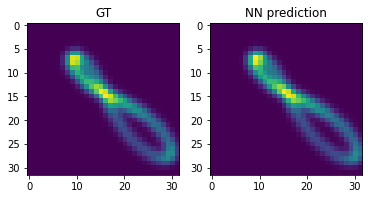

In [110]:
fig , ax = plt.subplots(1,2)
ax[0].imshow(gen_img.reshape(32,32).detach().cpu())
ax[0].set_title("GT")
ax[1].imshow(gen_img_from_nn.reshape(32,32).detach().cpu())
ax[1].set_title("NN prediction")
plt.show()